# Project: Amazon reviews classification using XGboost, Random Forest Classifier and Neural Networks

## 1. Data Preprocessing

In [0]:
%%capture
!pip install -U gensim
!pip install urllib2

In [0]:
import gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

from datetime import *
from operator import itemgetter

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

In [0]:
def make_tfidf(reviews_bow):
  model = TfidfModel(reviews_bow, normalize=True)
  vector = model[reviews_bow]

  return vector

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

In [0]:
def densify(sparse, columns):
  matrix = np.zeros((len(sparse),columns))

  row_num = 0
  for line in sparse:
    for id,count in line:
      matrix[row_num][id] = count
    row_num += 1    
  return matrix

Initially, the matrix of corpus is sparse and dimensions are huge. From Homework4, I choose the cutoff number to be 40 and use this dense matrix as the training set for 



In [0]:
cutoff = 40
np.random.seed(1911)

lsmodel = LsiModel(reviews_tfidf, id2word=reviews_dict,num_topics=cutoff)
X = densify(lsmodel[reviews_tfidf],cutoff)

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)

## 2. XGboost/RandomForest/Neural Network

### 2.1 Try out on XGBoost classifier

In [11]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

acc_xgb = xgb.score(X_test, y_test)

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 0.78


### 2.2 Try out on RandomForest classifier

In [12]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
acc_rfc = rfc.score(X_test, y_test)
print("Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

Random Forest Classifier's prediction accuracy is: 0.80


### 2.3 Try out on Neural Network

Try out on artificial neural network, in these neural network architecture, model, I used three densed layer and a softmax output. The optimizer I choose here is Adam optimizer and train 50 epoches.

Since there is no definite implementation about how to select number of neurons. According to experience, I set numbers of neurons as 50->100->60 to adjust them later.

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD,Adam,Nadam
from keras import callbacks
from sklearn import preprocessing

one_hot_y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = ms.train_test_split(X, one_hot_y, test_size=0.2, random_state = 1911)

model = Sequential()

model.add(Dense(50, activation='relu', input_dim=np.array(X_train).shape[1])) # dimmension of each example

model.add(Dense(150, activation='relu'))

model.add(Dense(60, activation='relu'))

model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_history = model.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_test, y_test))




Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 80000 samples, validate on 20000 samples
Epoch 1/50





80000/80000 [==============================] - 8s 104us/step - loss: 0.7043 - acc: 0.7680 - val_loss: 0.5975 - val_acc: 0.7972
Epoch 2/50
80000/80000 [==============================] - 4s 45us/step - loss: 0.5743 - acc: 0.7974 - val_loss: 0.5770 - val_acc: 0.8001
Epoch 3/50
80000/80000 [==============================] - 4s 46us/step - loss: 0.5595 - acc: 0.8020 - val_loss: 0.5599 - val_acc: 0.8067
Epoch 4/50
80000/80000 [==============================] - 4s 47us/step - loss: 0.5485 - acc: 0.8050 - val_loss: 0.5530 - val_acc: 0.8085
Epoch 5/50
80000/80000 [==============================] - 4s 46us/step - loss: 0.5379 - acc: 0.8086 - val_loss: 0.5425 - val_acc: 0.8095
Epoch 6/50
80000/80000 [==============================] - 4s 46us/step - loss: 0.5314 - acc: 0.8105 - val_loss: 0.5382 - val_acc: 0.8117
Epoch 7/50
80000/800

In [0]:
model.summary()

In [14]:
NN_accuracy = model.evaluate(X_test, y_test, batch_size=128)[-1]
print(NN_accuracy)

20000/20000 [==============================] - 0s 14us/step
0.82205


#### 2.3.1 Visualize trainning process

Plot the figure of training loss, it is shown that after 30 epoches, the loss of test set will only decrease a litte, which means the model has reached its limit

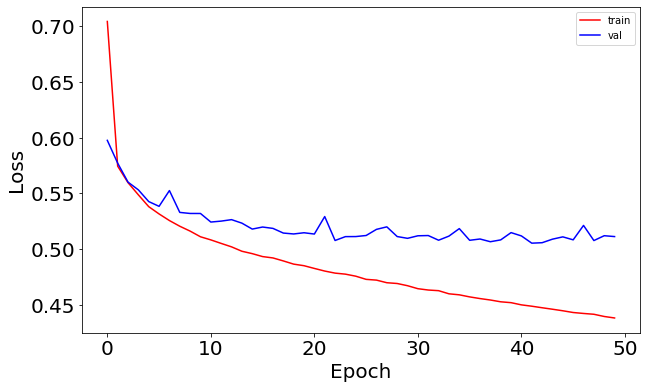

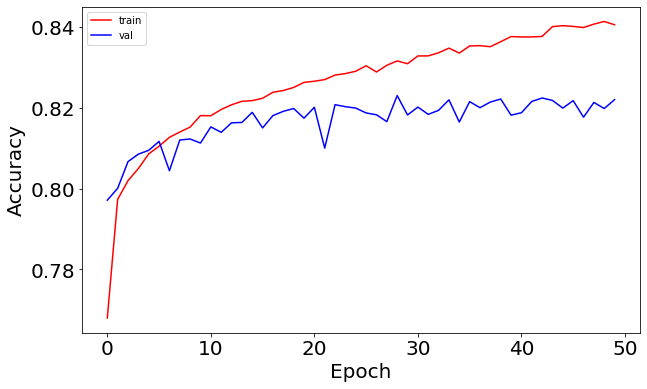

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(model_history.history['loss'], 'r', label='train')
ax.plot(model_history.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(model_history.history['acc'], 'r', label='train')
ax.plot(model_history.history['val_acc'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### 2.3.2 Get confusion matrix

In [16]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test.as_matrix(),axis=1)


print(confusion_matrix(y_true, y_pred))

[[3342  102   97  213  197]
 [  77 3369  195  251  148]
 [  42  101 3548  215   83]
 [  81  103  470 3130  222]
 [ 136  170  204  452 3052]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


#### 2.3.3 Precison and recalls for each class

In [17]:
from sklearn.metrics import precision_recall_fscore_support


precision,recall,_,_ = precision_recall_fscore_support(y_true, y_pred)
print(precision)
print(recall)


[0.908646   0.87620286 0.78599911 0.73456935 0.82441923]
[0.84586181 0.83391089 0.88944598 0.78132801 0.76033881]


It can be seen that the precison of 1-star ratings is much accurate than other reviews.

## 3. LSTM 

The three models above using a dataset of shape(100000, 40), which is the result of PCA. The next part will be discussing the performance of LSTM in natural language processing. LSTM has good performance in prediciting sequential data. Plus, I trained our own word embeddings in the model to improve performance.

### 3.1 Tokenize the corpus and pad each sentences

In [0]:
def translate_review(review, reviews_dict):
  
  word_list = []
  for id,counts in review:
    word = reviews_dict[id]
    for count in range(1,int(counts)+1):
      word_list.append(word)      
  return ' '.join(word for word in word_list)  

In [0]:
docs = [doc for doc in reviews_bow]
text_matrix = [translate_review(docs[i], reviews_dict) for i in range(len(reviews_bow))]

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = len(reviews_dict))
tokenizer.fit_on_texts(text_matrix)
tokenized_text = tokenizer.texts_to_sequences(text_matrix)
X_sequence = pad_sequences(tokenized_text, maxlen=800)

### 3.2 Build LSTM and training

In [21]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

one_hot_y = pd.get_dummies(y)

Xl_train, Xl_test, yl_train, yl_test = ms.train_test_split(X_sequence, one_hot_y, test_size=0.2, random_state = 1911)

max_features = len(reviews_dict)
lsmodel = Sequential()

lsmodel.add(Embedding(max_features, 128))
lsmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lsmodel.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
lsmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


lsmodel_history = lsmodel.fit(Xl_train,yl_train,batch_size=128,epochs=5,validation_data=(Xl_test, yl_test))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 992s 12ms/step - loss: 0.5755 - acc: 0.7962 - val_loss: 0.3849 - val_acc: 0.8708
Epoch 2/5
80000/80000 [==============================] - 987s 12ms/step - loss: 0.3025 - acc: 0.8968 - val_loss: 0.3892 - val_acc: 0.8694
Epoch 3/5
80000/80000 [==============================] - 994s 12ms/step - loss: 0.2452 - acc: 0.9157 - val_loss: 0.4201 - val_acc: 0.8651
Epoch 4/5
80000/80000 [==============================] - 996s 12ms/step - loss: 0.2096 - acc: 0.9274 - val_loss: 0.4432 - val_acc: 0.8629
Epoch 5/5
80000/80000 [==============================] - 991s 12ms/step - loss: 0.1841 - acc: 0.9353 - val_loss: 0.4813 - val_acc: 0.8569


In [22]:
lsmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2395648   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 2,527,877
Trainable params: 2,527,877
Non-trainable params: 0
_________________________________________________________________


### Appendix: Relationship between star ratings and time



In [0]:
converted_times = []
for time in reviews_times:
  converted_times.append(datetime.fromtimestamp(time))

plot the histogram of star ratings and see how these ratings are distributed, as is shown, the dataset we use don't have  any bias and each category has 20000 reviews

(array([20000.,     0., 20000.,     0.,     0., 20000.,     0., 20000.,
            0., 20000.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

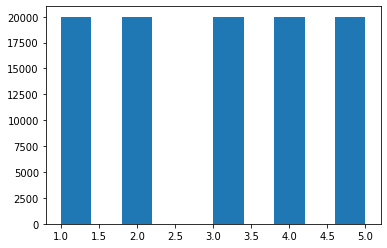

In [25]:
plt.hist(y)

Next, we can explore for each year, how star ratings are distributed.

In [0]:
df = pd.DataFrame(list(zip(y, converted_times)), 
               columns =['star_rating', 'time']) 

In [27]:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df

,star_rating,time,year,month
0,1,2012-05-06,2012,5
1,1,2014-04-07,2014,4
2,1,2012-07-17,2012,7
3,1,2014-07-14,2014,7
4,1,2013-05-16,2013,5
...,...,...,...,...
99995,5,2013-04-04,2013,4
99996,5,2010-09-21,2010,9
99997,5,2013-05-12,2013,5
99998,5,2013-03-05,2013,3


In [28]:
df.groupby('month')['star_rating'].mean()

month
1     2.979513
2     3.018744
3     3.004384
4     3.015224
5     3.041033
6     3.005587
7     3.010848
8     2.957945
9     3.048466
10    3.020286
11    2.950520
12    2.955125
Name: star_rating, dtype: float64

In [29]:
df.groupby('year')['star_rating'].mean()

year
2001    2.000000
2002    2.320000
2003    2.140351
2004    2.105634
2005    2.267559
2006    2.460829
2007    2.977995
2008    3.108295
2009    3.122060
2010    2.976670
2011    2.905261
2012    2.955380
2013    3.028766
2014    3.020814
Name: star_rating, dtype: float64

From January to December, it can be seen that the average score of star rating is around 3.0. However, from 2001 to 2014, the average star rating grows from 2.0 to 3.0, which means maybe we can incorporate the time series in our model.